## Construire des systèmes de recommandation à l'aide de réseaux neuronaux graphiques (GNN)


    



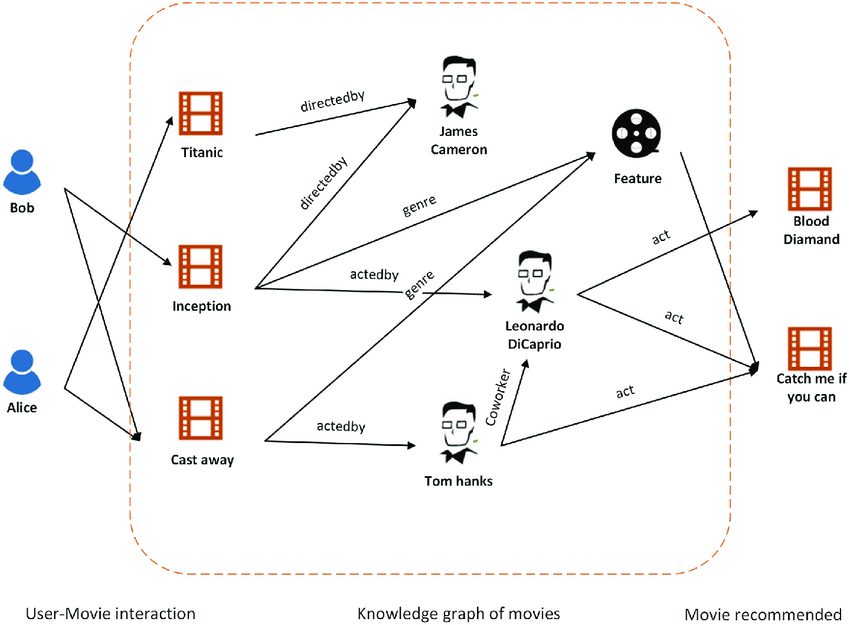

    

*Source de l'image : Xintao et.al.*

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/Recommender_Systems/GNNs_for_Recommendations_French.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2024. Licence Apache 2.0.

**Auteurs :** [Jama Hussein Mohamud](https://engmubarak48.github.io/jmohamud/)

**Relecteurs :**
[Matthew Morris](https://www.cs.ox.ac.uk/people/matthew.morris/)

**Introduction :**

Ce tutoriel s'appuie sur les connaissances acquises dans les tutoriels sur les réseaux neuronaux graphiques (GNN) et les systèmes de recommandation. Dans cette section, nous allons montrer comment exploiter les GNN dans les systèmes de recommandation. Pendant votre temps libre, n'hésitez pas à consulter cette [introduction](https://aman.ai/recsys/gnn/) approfondie sur les GNN pour les systèmes de recommandation.

**Prérequis :**

- Familiarité avec JAX, en particulier Flax et Jraph
- Une solide compréhension des fondements des réseaux neuronaux
- Avoir suivi le tutoriel sur les réseaux neuronaux graphiques (GNN)
- Avoir suivi le tutoriel sur les systèmes de recommandation

**Objectifs d'apprentissage :**
- Cadrer les tâches de prédiction de liens dans le contexte des recommandations de films
- Implémenter un réseau neuronal convolutif de graphes (GCN) pour les recommandations de films

**Sujets :**

Contenu : ML, systèmes de recommandation, réseaux neuronaux graphiques
    


###  Configuration, installation et données


Veuillez exécuter les cellules ci-dessous avant de commencer le tutoriel.


Nous utiliserons `jraph`, une bibliothèque pour travailler avec des réseaux neuronaux graphiques dans JAX.

Exécutez la cellule suivante pour installer `jraph` et télécharger les données :
    


In [ ]:
%%capture
# Installations
!pip install git+https://github.com/deepmind/jraph.git
# téléchargement des données du graphique
!wget https://github.com/engmubarak48/indaba-pracs-2024/blob/recommender-systems/practicals/data.pt


#### Importer les bibliothèques requises

Dans cette section, nous allons importer les bibliothèques nécessaires à notre système de recommandation basé sur les GNN.
Exécutez la cellule suivante pour importer les packages requis :
    


In [ ]:
# @title Importer les packages requis.

import jax
import jraph
import optax
import torch
import itertools
import numpy as np
import pandas as pd
from flax import linen as nn
from jax import numpy as jnp
import jax.tree_util as tree
import matplotlib.pyplot as plt
from jraph import GraphConvolution
from flax.training import train_state
from typing import Mapping, Sequence, Tuple, Callable



### **1.1 Introduction**

Les graphes sont une représentation puissante et polyvalente des données avec un large éventail d'applications. Alors que la plupart des gens sont familiers avec leur utilisation dans des contextes tels que les réseaux sociaux et les systèmes biologiques, les graphes ont également été utilisés dans les systèmes de recommandation, qui est l'objet de ce tutoriel.
    


### **1.2. Tâches de prédiction de graphes**

Comme démontré dans le tutoriel sur les GNN, il existe principalement trois tâches de graphes dans le contexte des réseaux neuronaux de graphes :

1. **Classification de nœuds** : Par exemple, quel est le sujet d'un article scientifique étant donné un réseau de citations d'articles ?
2. **Prédiction de liens / Classification d'arêtes** : Par exemple, deux personnes dans un réseau social sont-elles amies ?
3. **Classification de graphes** : Par exemple, cette molécule de protéine (représentée sous forme de graphe) est-elle susceptible d'être efficace ?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*Source de l'image : Petar Veličković.*


### **1.3. Les systèmes de recommandation comme problème de prédiction de liens**

Un système de recommandation peut être visualisé comme un graphe, où les entités (telles que les utilisateurs et les articles) sont des nœuds, et les interactions entre elles (telles que les évaluations ou l'historique d'achat) sont des arêtes. Dans le système de recommandation de films :

- Les nœuds représentent :
  - Utilisateurs : Individus consommant le contenu
  - Films : Éléments de contenu à recommander

- Les arêtes représentent :
  - Évaluations : Arêtes dirigées des utilisateurs vers les films, pondérées pour indiquer l'évaluation (par exemple, sur une échelle de 1 à 5)
    


#### 1.3.1. Prédiction de liens (ou d'arêtes)

La prédiction de liens vise à déterminer si un lien (ou une arête) devrait exister entre deux nœuds, même s'il est actuellement absent. Dans notre système de recommandation de films, cela se traduit par la prédiction de savoir si un utilisateur aimerait (ou n'aimerait pas) un film qu'il n'a pas encore noté.

Le processus fonctionne comme suit :

1. S'entraîner sur les nœuds et les arêtes existants : utiliser les caractéristiques des arêtes existantes (par exemple, la note) et les caractéristiques des nœuds utilisateur-film (par exemple, les genres de films) pour entraîner un modèle.
2. Prédire les arêtes manquantes : pour un utilisateur donné, prédire les notes pour les films qu'il n'a pas vus ou notés. Cela équivaut à prédire les arêtes manquantes ou potentielles dans notre graphe.
3. Recommander en fonction des prédictions : suggérer à l'utilisateur les films ayant les notes prédites les plus élevées.

Dans cette section du tutoriel, nous allons exploiter les réseaux neuronaux graphiques (GNN) pour cette tâche de prédiction de liens. Les GNN opèrent sur le graphe, en agrégeant les informations des nœuds voisins pour produire des prédictions précises pour les arêtes manquantes.


#### **1.4 Lecture des données**

Dans cette section, nous chargeons une version de graphe pré-traitée des données MovieLens, utilisée dans le tutoriel sur les systèmes de recommandation, à partir d'un objet PyTorch Geometric Data enregistré sous le nom `data.pt`.

Cette représentation graphique est préparée pour être utilisée avec notre modèle GNN et sera la principale structure de données utilisée pendant l'entraînement du modèle. Si vous souhaitez savoir comment nous avons transformé les données MovieLens originales en un format de graphe, veuillez vous référer au fichier [generate_graph.py](https://github.com/engmubarak48/indaba-pracs-2024/blob/recommender-systems/practicals/generate_graph.py). Notez que contrairement au [tutoriel](https://github.com/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/Recommender_Systems.ipynb) de l'année dernière, où les caractéristiques des nœuds utilisateur étaient générées aléatoirement à partir d'une matrice  d'incorporation (embedding), dans ce tutoriel, nous utiliserons l' incorporation de caractéristiques appris pour chaque utilisateur.


In [ ]:
#@title Données

# Charger les données du graph (graphe)
data = torch.load(f"data.pt")
data.keys



`num_users` indique le nombre total d'utilisateurs uniques dans l'ensemble de données.


In [ ]:
data.num_users


Le `movie_id_to_title` est simplement une correspondance entre les ID utilisateur et les titres de films correspondants dans le graphe. Nous l'utiliserons pour l'inférence.


In [ ]:
# affiche 5 éléments de movie_id_to_title

dict(itertools.islice(data.movie_id_to_title.items(), 5))


`x` contient la matrice des caractéristiques des nœuds où chaque ligne représente un nœud (utilisateur ou film) et les colonnes sont des valeurs de caractéristiques.


In [ ]:
# caractéristiques des nœuds
print('les 5 premières caractéristiques des nœuds utilisateur')
print(data.x[:5])

print('les 5 dernières caractéristiques des nœuds de film')
print(data.x[-5:])



Dans les caractéristiques des nœuds (`x`), les caractéristiques correspondant aux utilisateurs sont initialement définies à zéro. Celles-ci seront remplacées dans le modèle par des caractéristiques de plongement apprises (c'est-à-dire que chaque utilisateur aura un plongement qui est appris pendant l'entraînement du modèle). Les caractéristiques des nœuds de film, d'autre part, sont représentées en utilisant un encodage one-hot des genres de films. Bien qu'il soit possible d'inclure les titres de films dans les caractéristiques des nœuds, nous avons opté pour la simplicité dans ce tutoriel et n'utilisons qu'un encodage one-hot des genres de films.


L'`edge_attr` contient les caractéristiques des arêtes qui, dans notre cas, correspondent aux notes des utilisateurs.


In [ ]:
# caractéristiques des arêtes
data.edge_attr[:5]


L'`edge_index` est un élément clé de la structure de notre graphe, représentant les connexions entre les nœuds. Dans notre système de recommandation de films, chaque entrée dans l'`edge_index` montre un lien entre un utilisateur et un film.


In [ ]:
# edge index
print(data.edge_index[:3])



`train_mask` est un masque booléen utilisé pour sélectionner le sous-ensemble de données (arêtes) pour l'entraînement. `val_mask` et `test_mask` sont identiques mais pour les ensembles de validation et de test respectivement.


In [ ]:
# masques

print(f'3 premiers éléments du masque d\'entraînement : {data.train_mask.flatten()[:3]}')
print(f'3 premiers éléments du masque de validation : {data.val_mask.flatten()[:3]}')
print(f'3 premiers éléments du masque de test : {data.test_mask.flatten()[:3]}')


Faisons une exploration préliminaire des données. Par exemple, affichons le nombre d'utilisateurs et de films uniques.


In [ ]:
# Nombre d'utilisateurs uniques
num_users = data.num_users
print(f"Number of unique users: {num_users}")

# Nombre de films uniques
num_movies = len(data.movie_id_to_title)
print(f"Number of unique movies: {num_movies}")


Ci-dessous, nous allons visualiser la distribution des évaluations des utilisateurs.


In [ ]:
import matplotlib.pyplot as plt

# Extract ratings from edge_attr
ratings = data.edge_attr.numpy()

# Plot the distribution of ratings (ratings)
plt.hist(ratings, bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Fréquence')
plt.title('Distribution des évaluations')
plt.show()


On peut observer que les évaluations les plus fréquentes sont 3 et 4.


Il faut transformer nos données de graphe dans un format que Jax's `Jraph` framework peut utiliser. La fonction ci-dessous convertit notre graphe en `jraph.GraphsTuple`, qui est compatible avec la librairie Jraph.


In [ ]:
#@title Fonction utilitaire

# Une fonction utilitaire pour convertir nos données de graphe en jraph.GraphsTuple
def convert_to_jraph(data):
    """ Convertir l'objet Pytorch Data """
    graph = jraph.GraphsTuple(
        nodes=np.array(data.x),
        edges=np.array(data.edge_attr),
        n_node=np.array([data.num_nodes]),
        n_edge=np.array([data.num_edges]),
        senders=np.array(data.edge_index[0]),  # les utilisateurs sont la source (source)
        receivers=np.array(data.edge_index[1]),  # les films sont les récepteurs (recievers)
        globals={"num_users": data.num_users},
    )
    train_mask, val_mask, test_mask = np.array(data.train_mask), np.array(data.val_mask), np.array(data.test_mask)
    return graph, train_mask, val_mask, test_mask



In [ ]:
#@title Convertir le graphe en jraph.GraphsTuple

graph, train_mask, val_mask, test_mask = convert_to_jraph(data=data)
graph




#### **1.5 Graph Convolutional Networks (GCNs) dans les systèmes de recommandation**

Nous utiliserons un réseau neuronal convolutif de graphes (GCN) comme modèle. Les GCN sont bien adaptés aux systèmes de recommandation, car ils permettent de relever des défis clés :

- **Gestion des données éparses** : Ils gèrent efficacement les interactions utilisateur-item clairsemées en utilisant la structure inhérente du graphe.
- **Capture des relations complexes** : Les GCN excellent à apprendre les relations complexes et non linéaires représentées dans le graphe d'interaction utilisateur-item.
- **Incorporation d'informations complémentaires** : Ils permettent d'intégrer des caractéristiques supplémentaires telles que la notation des utilisateurs, les données démographiques ou les descriptions des articles directement dans le graphe.

Pour une compréhension plus approfondie de l'architecture des GCN, veuillez consulter le tutoriel sur les GNN et les autres ressources fournies au début de ce tutoriel.


La classe ci-dessous définit un module simple de perceptron multicouche (MLP) qui met à jour les caractéristiques pendant la propagation des messages dans notre GCN.
    


In [ ]:
#@title task

class MLP(nn.Module):
  """Un MLP Flax.""" # MLP is not translated as it is a technical term
  features: Sequence[int]
  kernel_init: Callable = jax.nn.initializers.he_uniform()
  bias_init: Callable = jax.nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
        lyr = nn.Dense(feat, kernel_init=self.kernel_init, bias_init=self.bias_init, name=f"mlp_dense_{i}")
        x = # Appliquer la couche dense à x (Apply the dense layer to x)
        x = # Ajouter une non-linéarité relu (Add relu non-linearity)
        if i != len(self.features) - 1:
            x = nn.relu(x)
    return x


In [ ]:
#@title Solution

class MLP(nn.Module):
  """Un MLP Flax.""" # MLP is not translated as it is a technical term
  features: Sequence[int]
  kernel_init: Callable = jax.nn.initializers.he_uniform()
  bias_init: Callable = jax.nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
        lyr = nn.Dense(feat, kernel_init=self.kernel_init, bias_init=self.bias_init, name=f"mlp_dense_{i}")
        x = lyr(x)
        x = nn.relu(x)
        if i != len(self.features) - 1:
            x = nn.relu(x)
    return x


##### **1.5.1 Couche de convolution de graphe**

Cette classe implémente une couche de convolution de graphe qui commence par incorporer les caractéristiques de l'utilisateur, puis les combine avec des nœuds de film pour les traiter à travers le réseau. La couche utilise un mécanisme d'attention pour pondérer l'importance des arêtes, agrégeant ainsi les messages aux nœuds. Une normalisation optionnelle des couches peut être appliquée pour stabiliser le modèle pendant l'entraînement. Enfin, elle prédit les valeurs des arêtes à l'aide d'une simple couche dense et met ces prédictions à l'échelle de 1 à 5.

Le mécanisme d'attention de ce modèle est déterminé uniquement en fonction des caractéristiques des arêtes, et non des caractéristiques des nœuds connectés, ce qui le rapproche davantage des réseaux d'attention de graphe (GAT) que des réseaux de convolution de graphe (GCN) traditionnels. Dans les GAT, les coefficients d'attention sont calculés pour indiquer l'importance de chaque nœud pour ses voisins, améliorant ainsi la capacité du modèle à capturer des données relationnelles complexes.

Pour ceux qui connaissent les GCN grâce à notre tutoriel GNN, la principale différence ici réside dans la manière dont la connectivité des nœuds influence le processus d'agrégation. Alors que les GCN utilisent une simple somme pondérée basée sur les poids des arêtes, les GAT, comme notre modèle, ajustent ces poids grâce à un mécanisme d'attention appris.

Si le concept d'attention est nouveau pour vous, ou si vous avez besoin d'une compréhension plus détaillée du fonctionnement des GAT, veuillez vous référer aux sections étendues de la pratique GNN où les GAT sont abordés plus en profondeur.


In [ ]:
#@title task

# Définition du modèle de convolution de graphe

class GraphConvLayer(nn.Module):
    output_decoder_dim: int # dimension de sortie du décodeur
    num_user_nodes: int # nombre de nœuds utilisateur
    update_node_fn: Callable
    attention_logit_fn: Callable
    aggregate_nodes_fn: Callable = jax.ops.segment_sum
    add_self_edges: bool = False
    symmetric_normalization: bool = True
    layer_norm: bool = False

    @nn.compact
    def __call__(self, graph):
        # Incorporer les caractéristiques de l'utilisateur
        user_indices = jnp.arange(self.num_user_nodes)
        emb = nn.Embed(self.num_user_nodes, graph.nodes.shape[1])
        user_embeddings = emb(user_indices)

        # graph.nodes doit être structuré de manière à ce que les nœuds utilisateur viennent en premier, suivis des nœuds de film
        nodes = jnp.concatenate([user_embeddings, graph.nodes[self.num_user_nodes:]], axis=0)
        edge_weights = self.attention_logit_fn(graph.edges) # poids des arêtes
        edge_weights = jraph.segment_softmax(edge_weights, segment_ids=graph.receivers, num_segments=nodes.shape[0])
        messages = graph.nodes[graph.senders] * edge_weights # Multiplier les messages de l'expéditeur par les poids des arêtes
        nodes = self.aggregate_nodes_fn(messages, graph.receivers, num_segments=graph.nodes.shape[0])
        graph = graph._replace(nodes=nodes)

        gcn = GraphConvolution(
            update_node_fn=self.update_node_fn,
            aggregate_nodes_fn=self.aggregate_nodes_fn,
            add_self_edges=self.add_self_edges,
            symmetric_normalization=self.symmetric_normalization
        )
        graph = gcn(graph) # Appliquer gcn au graphe
        if self.layer_norm:
            # Appliquer la normalisation de couche aux plongements de nœuds
            normalized_nodes = nn.LayerNorm()(graph.nodes)
            graph = graph._replace(nodes=normalized_nodes) # Mettre à jour le graphe avec les plongements de nœuds normalisés

        edge_predictions = jnp.sum(graph.nodes[graph.senders] * graph.nodes[graph.receivers], axis=-1) # prédictions des arêtes
        edge_predictions = jnp.expand_dims(edge_predictions, axis=1)
        edge_predictions = nn.Dense(self.output_decoder_dim, name="mlp_dense_output")(edge_predictions)


        edge_predictions = nn.sigmoid(edge_predictions) * 5  # Appliquer l'activation sigmoïde aux prédictions des arêtes (edge_predictions) et la mettre à l'échelle de 1 à 5
        return edge_predictions




In [ ]:
#@title Solution

class GraphConvLayer(nn.Module):
    output_decoder_dim: int
    num_user_nodes: int
    update_node_fn: Callable
    attention_logit_fn: Callable
    aggregate_nodes_fn: Callable = jax.ops.segment_sum
    add_self_edges: bool = False
    symmetric_normalization: bool = True
    layer_norm: bool = False

    @nn.compact
    def __call__(self, graph):
        # Incorporer les caractéristiques de l'utilisateur
        user_indices = jnp.arange(self.num_user_nodes)
        emb = nn.Embed(self.num_user_nodes, graph.nodes.shape[1])
        user_embeddings = emb(user_indices)

        # graph.nodes doit être structuré de manière à ce que les nœuds utilisateur viennent en premier, suivis des nœuds de film
        nodes = jnp.concatenate([user_embeddings, graph.nodes[self.num_user_nodes:]], axis=0)
        edge_weights = self.attention_logit_fn(graph.edges)
        edge_weights = jraph.segment_softmax(edge_weights, segment_ids=graph.receivers, num_segments=nodes.shape[0])
        messages =  nodes[graph.senders] * edge_weights
        nodes = self.aggregate_nodes_fn(messages, graph.receivers, num_segments=graph.nodes.shape[0])
        graph = graph._replace(nodes=nodes)

        gcn = GraphConvolution(
            update_node_fn=self.update_node_fn,
            aggregate_nodes_fn=self.aggregate_nodes_fn,
            add_self_edges=self.add_self_edges,
            symmetric_normalization=self.symmetric_normalization
        )
        graph = gcn(graph)
        if self.layer_norm:
            # Appliquer la normalisation de couche aux plongements de nœuds
            normalized_nodes = nn.LayerNorm()(graph.nodes)
            # Mettre à jour le graphe avec les plongements de nœuds normalisés
            graph = graph._replace(nodes=normalized_nodes)

        edge_predictions = jnp.sum(graph.nodes[graph.senders] * graph.nodes[graph.receivers], axis=-1)
        edge_predictions = jnp.expand_dims(edge_predictions, axis=1)
        edge_predictions = nn.Dense(self.output_decoder_dim, name="mlp_dense_output")(edge_predictions)

        # Appliquer l'activation sigmoïde et la mettre à l'échelle
        edge_predictions = 4 * jax.nn.sigmoid(edge_predictions) + 1
        return edge_predictions



##### Initialiser la couche GCN

Ici, nous définissons un réseau neuronal convolutif de graphes (GCN) à une seule couche avec des fonctions spécifiques pour l'attention, les mises à jour de nœuds et l'agrégation.
Nous initialisons le modèle pour vérifier les formes de sortie, en nous assurant que tout est correctement configuré avant l'entraînement.


In [ ]:
# Définir une couche gcn
gcn_layer = GraphConvLayer(
    output_decoder_dim = 1,
    attention_logit_fn=lambda n: MLP(features=[64, 1])(n),
    update_node_fn=lambda n: MLP(features=[64, 64])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=False,
    symmetric_normalization=True,
    num_user_nodes=graph.globals['num_users'],
)

# Initialiser pour voir les formes de sortie (output)
params = gcn_layer.init(jax.random.PRNGKey(42), graph)
output = gcn_layer.apply(params, graph)
output.shape, graph.edges.shape



##### Définir la fonction de perte L1

Cette fonction calcule la perte L1, qui mesure la différence entre les valeurs prédites et les valeurs réelles. Nous appliquons un masque pour se concentrer uniquement sur les ensembles d'entraînement (train), de validation (val) ou de test.
Vous pouvez choisir de faire la moyenne de la perte sur tous les points de données ou de la sommer.


In [ ]:
#@title task

# fonction de perte

def l1_loss(logits: np.ndarray, y: np.ndarray, mask: np.array, reduction: str = "mean") -> np.ndarray:
    """Implémentation de la perte l1.

    Args:
        logits: logits de sortie du modèle.
        y: étiquettes de classe.
        reduction: si la reduction est "mean", la moyenne est retournée, sinon si c'est "sum", la somme est retournée.

    Returns:
       perte l1.
    """
    logits_masked = logits * mask.astype(int)
    preds_masked = y * mask.astype(int)
    if reduction == "mean":
        loss = jnp.mean(jnp.abs(logits_masked - preds_masked))
    if reduction == "sum":
        loss = # calculer la perte lorsque reduction = "sum"

    return loss

# vérifier la perte aléatoire sans entraînement
l1_loss(output, graph.edges, mask=val_mask)




In [ ]:
#@title solution
def l1_loss(logits: np.ndarray, y: np.ndarray, mask: np.array, reduction: str = "mean") -> np.ndarray:
    """Implémentation de la perte l1.

    Args:
        logits: logits de sortie du modèle.
        y: étiquettes de classe.
        reduction: si la reduction est "mean", la moyenne est retournée, sinon si c'est "sum", la somme est retournée.

    Returns:
       perte l1.
    """
    logits_masked = logits * mask.astype(int)
    preds_masked = y * mask.astype(int)
    if reduction == "mean":
        loss = jnp.mean(jnp.abs(logits_masked - preds_masked))
    if reduction == "sum":
        loss = jnp.sum(jnp.abs(logits_masked - preds_masked))

    return loss

# vérifier la perte aléatoire sans entraînement
l1_loss(output, graph.edges, mask=val_mask)



##### Initialiser l'état de l'apprentissage

Nous configurons l'environnement d'apprentissage en créant un `TrainState`. Cela comprend l'initialisation du modèle avec des configurations spécifiques et la création d'un optimiseur. La fonction `create_train_state` prépare le modèle, configure l'optimiseur et indique le nombre total de paramètres dans le modèle.
    


In [ ]:
#@title Définir l'état de l'apprentissage flax
def create_train_state(
    model, graph, tx, rngs
):
    """État de l'apprentissage. Cette fonction initialise le modèle."""

    @jax.jit
    def initialize(params_rng):
        variables = model.init(
            params_rng,
            graph,
        )
        return variables

    variables = initialize(rngs)
    # (params = paramètres)
    state = train_state.TrainState.create(apply_fn=model.apply, params=variables["params"], tx=tx)

    param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
    print("Nombre de paramètres du modèle :", param_count)
    return state




##### Initialisation du modèle

Nous initialisons notre modèle ainsi que son état d'apprentissage, ses hyperparamètres et son optimiseur. Cette configuration est conçue pour être flexible, permettant des modifications et des expériences faciles avec différentes configurations.


In [ ]:
# Initialisation du modèle, de l'état d'apprentissage et des autres hyperparamètres
optimizer = optax.adam(learning_rate=0.0001)
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
rngs = {"params": rng, "dropout": init_rng}

model = GraphConvLayer(
    output_decoder_dim = 1,
    attention_logit_fn=lambda n: MLP(features=[64, 1])(n),
    update_node_fn=lambda n: MLP(features=[64, 64])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    layer_norm=True,
    symmetric_normalization=True,
    num_user_nodes=graph.globals['num_users'], # nombre d'utilisateurs
)

state = create_train_state(
    model=model,
    graph=graph,
    tx=optimizer,
    rngs=rngs,
)



Comme vous pouvez le voir, notre modèle a 18027 paramètres. Vous pouvez jouer avec cela en changeant les hyperparamètres du modèle. En particulier, vous pouvez ajuster les paramètres suivants pour expérimenter les performances du modèle :

- **Learning Rate** : modifiez le `learning_rate` dans l'optimiseur pour voir comment cela affecte l'apprentissage.
- **Paramètres du modèle** : modifiez les dimensions dans les couches `MLP` pour jouer avec la complexité du modèle.
- **Fonction d'agrégation** : remplacez le `aggregate_nodes_fn` par d'autres fonctions comme `jax.ops.segment_mean` pour voir différents effets d'agrégation.
- **Ajouter des arêtes propres (Add Self Edges)** : activez ou désactivez `add_self_edges` pour voir comment l'inclusion de boucles propres modifie les performances.
- **Normalisation de la couche (Layer Normalization)** : activez ou désactivez `layer_norm` pour tester son impact sur la régularisation du modèle.
- **Normalisation symétrique (Symmetric Normalization)** : ajustez `symmetric_normalization` pour explorer différentes techniques de normalisation sur les arêtes.


Cette fonction définit une seule étape d'apprentissage pour notre réseau neuronal de graphe. Elle prend l'état actuel de l'apprentissage, les données du graphe, les étiquettes, un masque pour concentrer le calcul de la perte sur un ensemble d'évaluation spécifique (par exemple, l'ensemble d'apprentissage) et des générateurs de nombres aléatoires utiles à la reproductibilité. La fonction calcule les gradients en fonction de la perte, met à jour les paramètres du modèle et renvoie le nouvel état ainsi que la perte et les logits.


In [ ]:
# @title Étape d'apprentissage
@jax.jit
def train_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    rngs: dict,
) -> Tuple[train_state.TrainState, tuple]:
    """Effectue une étape de mise à jour sur le graphe.

    Args:
        state: état de l'apprentissage.
        graph: caractéristiques des nœuds du graphe.
        labels: étiquettes des arêtes du graphe.
        mask: masque pour les étiquettes à considérer pour l'optimisation
        rngs: générateurs de nombres aléatoires pour le dropout

    Returns:
        État actuel de l'apprentissage, la perte et les logits.
    """
    step = state.step
    rngs = {name: jax.random.fold_in(rng, step) for name, rng in rngs.items()}

    def loss_fn(params, graph, labels):
        # Calcul des logits et de la perte résultante.
        variables = {"params": params}
        logits = state.apply_fn(
            variables,
            graph=graph,
            rngs=rngs,
        )
        loss = l1_loss(logits=logits, y=labels, mask=mask)
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params, graph, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, (loss, logits)


Cette fonction effectue une étape d'évaluation, en appliquant le modèle entraîné aux données de graphe fournies pour calculer les prédictions (logits) et la perte. Elle utilise l'état actuel du modèle, la structure du graphe, les étiquettes des arêtes et le masque de séparation.


In [ ]:
# @title task

# Étape d'évaluation
@jax.jit
def evaluate_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    dropout_rng: dict = None,
) -> tuple:
    """Effectue une étape d'évaluation sur un ensemble d'entrées."""
    variables = {"params": state.params}
    logits = state.apply_fn(
        variables,
        graph=graph,
        rngs=dropout_rng,
    )
    loss = # compute the loss function (calculer la fonction de perte)
    return (loss, logits)



In [ ]:
# @title Solution
@jax.jit
def evaluate_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    dropout_rng: dict = None,
) -> tuple:
    """Effectue une étape d'évaluation sur un ensemble d'entrées."""
    variables = {"params": state.params}
    logits = state.apply_fn(
        variables,
        graph=graph,
        rngs=dropout_rng,
    )
    loss = l1_loss(logits=logits, y=labels, mask=mask) # (loss: perte)
    return (loss, logits)


Cette fonction exécute les étapes d'apprentissage et d'évaluation sur N époques, applique le modèle aux données de graphe fournies et calcule les pertes d'apprentissage et de validation.


In [ ]:
# @title Fonction de boucle d'apprentissage (Train loop function)
def train_eval(state, graph, train_mask, val_mask, rng, epochs = 10):
    final_train_loss = []
    final_val_loss = []
    for epoch in range(epochs):
        rng, epoch_rng = jax.random.split(rng)
        epoch_rng = {"dropout": epoch_rng}

        # (train_loss -> perte d'apprentissage, train_logits -> logits d'apprentissage)
        state, (train_loss, train_logits) = train_step(state=state, graph=graph, labels=graph.edges, mask=train_mask, rngs = epoch_rng)
        # (val_loss -> perte de validation, val_logits -> logits de validation)
        val_loss, val_logits = evaluate_step(state=state, graph=graph, mask=val_mask, labels=graph.edges)
        print(f"Epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}")
        final_train_loss.append(train_loss.item())
        final_val_loss.append(val_loss.item())

    return (state, final_train_loss, final_val_loss)



Ensuite, nous pouvons exécuter `train_eval` pour entraîner le modèle pendant 100 epochs. Si tout est correct, nous nous attendons à ce que la perte diminue. Vous pouvez jouer avec le taux d'apprentissage et les hyperparamètres du modèle pour voir comment ils influencent les performances.


In [ ]:
# Entraîner le modèle
epochs = 100
final_state, final_train_loss, final_val_loss = train_eval(state=state, graph=graph, train_mask=train_mask, val_mask=val_mask, rng=rng, epochs = epochs)


Traçons les pertes d'entraînement et de validation.


In [ ]:
# Tracé des pertes
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), final_train_loss, label="Train Loss", marker='o')
plt.plot(range(epochs), final_val_loss, label="Validation Loss", marker='*')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### **2. Inférence**

Dans cette section, nous allons montrer comment extraire les N meilleurs films recommandés pour un utilisateur spécifique, sur la base du GNN entraîné. Puisque nous disposons déjà d'un ensemble de test d'arêtes via `test_mask`, nous allons l'utiliser pour illustrer l'inférence.
    


Prédire les évaluations à l'aide du modèle entraîné et obtenir l'évaluation de l'ensemble de test


In [ ]:
_, logits = evaluate_step(final_state, graph, labels=graph.edges, mask=test_mask)
predicted_ratings = np.array(logits[test_mask]) # (predicted_ratings : logits)
print(predicted_ratings)


Ensuite, extrayons les ID utilisateur et les ID de films de l'ensemble de test à partir de edge_index.


In [ ]:
user_ids = data.edge_index[0][data.test_mask[:, 0]].numpy()
movie_ids = data.edge_index[1][data.test_mask[:, 0]].numpy()


Créons un dataframe simple qui contient les IDs des utilisateurs, ainsi que le titre du film et la note correspondante.


In [ ]:
# Association des IDs de films aux titres (movie_id, movie_titles)
movie_titles = [data.movie_id_to_title.get(movie_id) for movie_id in movie_ids]

predicted_ratings_df = pd.DataFrame({
    'user_id': user_ids,
    'movie_title': movie_titles,
    'predicted_rating': np.round(predicted_ratings, 3)
})

predicted_ratings_df.head()



Obtenir les N meilleurs films recommandés pour un utilisateur.


In [ ]:
user_id = 600 # ID de l'utilisateur
assert user_id in set(user_ids), f"l’ID utilisateur n'existe pas, veuillez sélectionner parmi les ID utilisateur existants : {user_ids}"
N = 5

top_movies = predicted_ratings_df[predicted_ratings_df['user_id'] == user_id].sort_values(by='predicted_rating', ascending=False).head(N)
# (top_movies) contiendra les meilleurs films recommandés pour l'utilisateur (user_id)
top_N = top_movies[['movie_title', 'predicted_rating']].values.tolist()

print(f'Les {len(top_N)} meilleurs films recommandés pour l\'ID utilisateur {user_id} sont :')

for number, (movie_title, rating) in enumerate(top_N): # (movie_title, rating) <=> (titre du film, évaluation)
    print(f'{number + 1}: {movie_title} avec une évaluation prédite de {rating:.2f}')


Obtenez les N films les moins bien recommandés pour un utilisateur.


In [ ]:
# Obtenez les N films les moins bien notés pour un utilisateur.

user_id = 600
assert user_id in set(user_ids), f"User ID n'existe pas, veuillez sélectionner parmi les ID utilisateur existants : {user_ids}"
N = 2

bottom_movies = predicted_ratings_df[predicted_ratings_df['user_id'] == user_id].sort_values(by='predicted_rating', ascending=True).head(N)
bottom_N = bottom_movies[['movie_title', 'predicted_rating']].values.tolist()

print(f'Les {len(bottom_N)} films les moins bien notés recommandés pour l\'ID utilisateur {user_id} sont :')

for number, (movie_title, rating) in enumerate(bottom_N): # (movie_title = titre du film, rating = note)
    print(f'{number + 1}: {movie_title} avec une note prédite de {rating:.2f}')


## Conclusion
**Résumé:**

Dans cet exercice pratique, nous avons présenté comment utiliser les modèles GNN pour les systèmes de recommandation. Pour une meilleure compréhension de ce domaine, nous recommandons les références suivantes.

**Références :**
 - [CS224W: Machine Learning with Graphs](https://web.stanford.edu/class/cs224w/)
 - Blog [Eugene Yan](https://eugeneyan.com/tag/recsys/) RecSys
 - [ACM RecSys YouTube](https://www.youtube.com/channel/UC2nEn-yNA1BtdDNWziphPGA)
 - [Recommendation Systems • Graph Neural Networks](https://aman.ai/recsys/gnn/)


Pour d'autres travaux pratiques du Deep Learning Indaba, veuillez consulter [cette page](https://github.com/deep-learning-indaba/indaba-pracs-2024).
    


<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="25%" />
    
